In [1]:
import torch
import torchtext

import torchtext.transforms as T
import torchtext.functional as F

import matplotlib.pyplot as plt
from typing import List, Callable
from functools import lru_cache
from enum import Enum
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
from collections import Counter
from torch import nn,optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer, ngrams_iterator
from torchtext.datasets import WikiText2, WikiText103
from torchtext.vocab import build_vocab_from_iterator

In [2]:
import nltk
from nltk.corpus import stopwords

In [3]:
torch.__version__

'2.1.0+cu118'

In [4]:
torchtext.__version__

'0.16.0+cpu'

In [5]:
nltk.__version__

'3.8.1'

In [3]:
import os
os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

In [461]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

# input


In [4]:
unk_idex = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3
max_seq_len = 256

In [5]:
batch_size = 128
context_size = 5
min_frequency = 5

In [6]:
artifact_path = Path("artifacts/wikitext2")

In [7]:
tokenizer = get_tokenizer('basic_english')

In [8]:
def drop_title(text: str) -> bool:
    return not text.startswith("=") and not text.endswith("=")

In [9]:
def drop_short_text(tokens: list[str], context_size: int = 1) -> bool:
    return len(tokens) >= context_size

In [10]:
def drop_keywords(text: str, keywords: list[str]):
    return [word for word in text if word not in keywords]

In [11]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: bool(text))
        # .filter(drop_title)
        .map(tokenizer)
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        .filter(lambda tokens: drop_short_text(tokens, context_size))
#         .batch(batch_size)
        # .map(text_transform)
#         .map(lambda text: F.to_tensor(text, padding_value=padding_idx))
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [12]:
def get_context(batch: list, context_size: int = 5):
    """
    Args:
        batch: shape(batch_size, max_seq_len)

    Return:
        gram, context
    """
    new_batch = []

    # half_size
    half_size = context_size // 2
    if context_size < 3:
        raise ValueError("context size is too small.")
    elif context_size % 2 == 0:
        raise ValueError("context size should be odd.")

    for item in batch:
        gram_placeholder, context_placeholder = [], []
        for index in range(half_size, len(item) - half_size, 1):
            gram = item[index: index+1]
            context = item[index-half_size:index+half_size+1]
            context.pop(half_size)
            gram_placeholder.append(gram)
            context_placeholder.append(context)

        # debug
        if not gram_placeholder:
            print(item)

        gram_placeholder = torch.Tensor(gram_placeholder).long()
        context_placeholder = torch.Tensor(context_placeholder).long()
        new_batch.append([gram_placeholder, context_placeholder])

    return new_batch

In [13]:
train_datapipe, val_datapipe, test_datapipe = WikiText2("./data")

In [14]:
vocab = build_vocab_from_iterator(datapipe_factory(train_datapipe, context_size), specials=["<unk>", "<bos>", "<eos>", "<pad>"], min_freq=min_frequency)
vocab.set_default_index(vocab["<unk>"])

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [15]:
print("vocab size:", len(vocab))

vocab size: 20382


In [352]:
artifact_path.joinpath("vocab.json").write_text(json.dumps(list(vocab.get_stoi().keys())))

225881

In [174]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 'on',
 'as',
 's',
 'that',
 'for']

In [16]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

In [17]:
train_datapipe = datapipe_factory(
    train_datapipe,
    context_size,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    context_size,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    context_size,
    text_transform,
)

In [18]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    collate_fn=lambda data: get_context(data, context_size),
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=batch_size,
    collate_fn=lambda data: get_context(data, context_size),
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
    collate_fn=lambda data: get_context(data, context_size),
)

In [167]:
# check context size
# for data in train_datapipe:
#     if len(data) < 5:
#         print(data)
#         break

In [180]:
# sample
# for data in train_datapipe:
#     if len(data) > 5:
#         print(data)
#         print(vocab.lookup_tokens(data))
#         break

In [181]:
# count = 0
# for data in train_datapipe:
#   count += len(data)
# count

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


1993228

In [ ]:
# number of words in training corpurs
# wikitext2 count 1,993,228
# wikitext103 count 101,227,641

10780437

In [ ]:
# for batch in train_dataloader:
# #     print(len(batch))
#     for gram, context in batch:
#         if not gram.numel():
#             print(gram)
#             break
#         if not context.numel():
#             print(context)
#             break
# #         print(len(gram), len(context))
# #         break
#     if not batch:
#         break

# subsampling


In [19]:
def subsampling_probability(freqs, t):
  return 1 - (t/freqs).sqrt()

In [20]:
subsampling_threshold = 1e-5

In [21]:
counter = Counter()
for item in train_datapipe:
  counter.update(item)

In [22]:
word_counts = [counter.get(i, 0) for i in range(len(vocab))]
word_counts = torch.LongTensor(word_counts)

In [23]:
len(word_counts) == len(vocab)

True

In [24]:
word_freqs = word_counts / sum(word_counts)

In [361]:
word_freqs.shape

torch.Size([20382])

In [362]:
sum(word_freqs)

tensor(1.0000)

In [363]:
sum(word_counts)

tensor(2049228)

In [25]:
word_probs = subsampling_probability(word_freqs, subsampling_threshold).maximum(torch.zeros((1)))

Text(0, 0.5, 'drop probability')

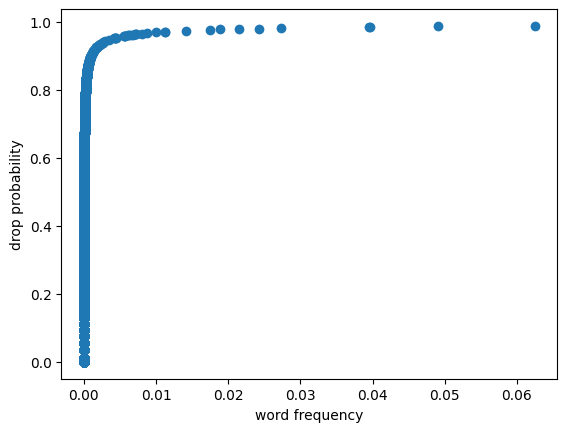

In [26]:
plt.scatter(word_freqs, word_probs)
plt.xlabel("word frequency")
plt.ylabel("drop probability")

In [366]:
# save word frequency
artifact_path.joinpath("word-count.json").write_text(json.dumps(word_counts.tolist()))

76211

In [196]:
# load word frequency
word_counts = json.loads(artifact_path.joinpath("word-count.json").read_text())
word_counts = torch.LongTensor(word_counts)

# model


In [27]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size: int, embed_dim: int, context_size: int):
        super(SkipGram, self).__init__()
        self.context_size = context_size

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        embed = self.embeddings(input).expand(-1, self.context_size-1, -1)
        out = self.linear(embed)
        return out

In [28]:
class CBOW(nn.Module):

    def __init__(self, vocab_size: int, embed_dim: int):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        embed = self.embeddings(input).sum(dim=1, keepdim=True)
        out = self.linear(embed)
        return out

# loss


In [65]:
class NegativeSampling(nn.Module):
    def __init__(self, device, word_freqs: torch.Tensor, negative_ratio: int = 5, power: float = 0.75):
        super(NegativeSampling, self).__init__()
        self.device = device
        self.negative_ratio = negative_ratio
        self.power = power
        self.word_freqs = word_freqs
        self.distribution = self.get_distribution()
        self.loss = nn.BCEWithLogitsLoss()

    @lru_cache
    def get_distribution(self):
        return nn.functional.normalize(self.word_freqs.pow(self.power), p=1, dim=0)

    def sample(self, num_negative_samples: int):
        noise_distribution = self.get_distribution()
        negative_samples = torch.multinomial(noise_distribution, num_negative_samples).to(self.device)

        return negative_samples

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        positive_loss = pred.gather(2, target.unsqueeze(2))

        num_subseq, positive_size = target.shape
        negative_target = self.sample(self.negative_ratio * num_subseq * positive_size).reshape(num_subseq * self.negative_ratio, positive_size)
        negative_loss = (1 - pred.repeat(self.negative_ratio, 1, 1).gather(2, negative_target.unsqueeze(2)))

        return self.loss(
            torch.cat([positive_loss, negative_loss], 0),
            torch.cat([torch.ones_like(positive_loss), torch.zeros_like(negative_loss)], 0),
        )

In [66]:
import heapq

class HuffmanNode:
    def __init__(self, char, freq, internal_index: int | None = None):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None
        self.internal_index = internal_index

    def __lt__(self, other):
        return self.freq < other.freq

    def __str__(self):
        return f"{self.char},{self.freq}"


    def __len__(self):
        node = self
        count = 1
        if node.left:
            count += len(node.left)
        if node.right:
            count += len(node.right)

        return count

In [74]:
class HierarchicalSoftmax(nn.Module):
    def __init__(self, device, word_counts: torch.Tensor, embed_dim: int, vocab_size: int):
        super(HierarchicalSoftmax, self).__init__()
        self.device = device
        self.word_counts = word_counts
        self.vocab_size = vocab_size

        self.tree = self.build_tree(embed_dim)
        self.paths = self.build_huffman_path(self.tree)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")
        self.layer = nn.Linear(embed_dim, vocab_size-1).to(device)

    def build_tree(self, embed_dim: int):
        priority_queue = [HuffmanNode(index, freq.item()) for index, freq in enumerate(self.word_counts)]
        heapq.heapify(priority_queue)

        internal_index = 0
        while len(priority_queue) > 1:
          left = heapq.heappop(priority_queue)
          right = heapq.heappop(priority_queue)
          combined_node = HuffmanNode(None, left.freq + right.freq, internal_index)
          combined_node.left = left
          combined_node.right = right
          internal_index += 1
          heapq.heappush(priority_queue, combined_node)

        if priority_queue[0].internal_index != (self.vocab_size - 2):
          print("Size of inner nodes is incorrect.")

        return priority_queue[0]

    def build_huffman_path(self, root: HuffmanNode, current_codes: list[int] = [], current_internal_indices: list[int] = [], huffman_codes={},):
      if root is not None:
          if root.char is not None:
              huffman_codes[root.char] = {
                 "code": torch.Tensor(current_codes).to(self.device),
                 "indices": torch.LongTensor(current_internal_indices).to(self.device),
              }
          self.build_huffman_path(root.left, current_codes + [0], current_internal_indices + [root.internal_index], huffman_codes)
          self.build_huffman_path(root.right, current_codes + [1], current_internal_indices + [root.internal_index], huffman_codes)
      return huffman_codes

    def calc_path_loss(self, pred: torch.Tensor, target: torch.Tensor):
      node_info = self.paths[target.item()]
      indices = node_info['indices']
      labels = node_info['code']

      return self.loss(pred[indices-1], labels)

    def forward(self, embedding: torch.Tensor, target: torch.Tensor):
      losses = 0

      subseq, _ = target.shape
      pred = self.layer(embedding).reshape(-1, self.vocab_size-1) # seq, context, vocab-1

      for idx, token in enumerate(target.flatten()):
        losses += self.calc_path_loss(pred[idx % subseq], token)

      return losses

In [75]:
# debug
# h = HierarchicalSoftmax("cpu", word_counts, 128, len(vocab))

In [76]:
# h.paths

In [77]:
# h.forward(
#     torch.randint(0, 1, (3, 1, 128)).float(),
#     torch.randint(0, 10, (3, 4)).float(),
# )

tensor(45.2503, grad_fn=<AddBackward0>)

# Final


In [78]:
class ModelType(Enum):
  CBOW = "CBOW"
  SKIP_GRAM = "SKIP_GRAM"

In [79]:
class LossType(Enum):
  NS = "NS"
  HS = "HS"
  CE = "CE"

In [80]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, context_size: int, model_type: ModelType, loss_type: LossType = LossType.CE):
        super(Word2Vec, self).__init__()
        self.model = self.build_model(model_type, loss_type, vocab_size, embed_dim, context_size)

    def build_model(self, model_type: ModelType, loss_type:LossType, vocab_size: int, embed_dim: int, context_size: int):
      if model_type == ModelType.CBOW:
        model = CBOW(vocab_size, embed_dim)
      elif model_type == ModelType.SKIP_GRAM:
        model = SkipGram(vocab_size, embed_dim, context_size)

      if loss_type == LossType.HS:
        model.linear = nn.Identity()

      return model

    @property
    def embeddings(self) -> nn.Module:
      return self.model.embeddings

    @staticmethod
    def subsampling(input: torch.Tensor, subsampling_probs: dict[int, float]) -> torch.Tensor:
      output = input * torch.bernoulli(subsampling_probs[input])
      return output

    def forward(self, input: torch.Tensor, word_probs: dict[int, float]|None = None):
      if word_probs is not None:
        output = self.subsampling(input, word_probs).long()
      else:
        output = nn.Identity()(input)

      return self.model(output)

# training


In [51]:
vocab_size = len(vocab)
vocab_size

20382

In [52]:
embed_dim = 300

In [53]:
epoches = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# input = torch.range(10).long()
# model(input)

## cross entropy


### SkipGram


In [54]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.SKIP_GRAM).to(device)

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            gram = gram.to(device)
            context = context.to(device)

            pred = model(gram, word_probs.to(device))
            loss = criterion(pred.transpose(1,2), context)
            running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

In [ ]:
torch.save(model, "models/sg.pth")

In [96]:
model = torch.load("models/sg.pth")

### CBOW


In [87]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.CBOW).to(device)

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            context = context.to(device)
            gram = gram.to(device)

            pred = model(context, word_probs.to(device))
            loss = criterion(pred.transpose(1,2), gram)

            running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

In [ ]:
torch.save(model, "models/cb.pth")

In [328]:
model = torch.load("models/cb.pth")

## NS


### SkipGram


In [367]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.SKIP_GRAM).to(device)

In [118]:
criterion = NegativeSampling(device, word_freqs)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            context = context.to(device)
            gram = gram.to(device)

            pred = model(gram, word_probs.to(device))
            loss = criterion(pred, context)

            running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

180it [01:07,  2.67it/s]


Epoch 1: 36.28033268451691


180it [01:05,  2.75it/s]


Epoch 2: 36.10806864500046


180it [01:05,  2.74it/s]


Epoch 3: 35.804463028907776


180it [01:06,  2.71it/s]


Epoch 4: 35.80097317695618


180it [01:06,  2.71it/s]


Epoch 5: 35.60616582632065


180it [01:06,  2.72it/s]


Epoch 6: 35.54139968752861


180it [01:06,  2.72it/s]


Epoch 7: 35.480569034814835


180it [01:06,  2.73it/s]


Epoch 8: 35.39726656675339


180it [01:05,  2.74it/s]


Epoch 9: 35.207111686468124


180it [01:06,  2.71it/s]


Epoch 10: 35.25894060730934


180it [01:06,  2.73it/s]


Epoch 11: 35.281426042318344


180it [01:06,  2.72it/s]


Epoch 12: 35.08335426449776


180it [01:06,  2.71it/s]


Epoch 13: 34.96698319911957


180it [01:06,  2.72it/s]


Epoch 14: 35.18055787682533


180it [01:06,  2.72it/s]


Epoch 15: 34.837773859500885


180it [01:06,  2.72it/s]


Epoch 16: 35.02310487627983


180it [01:05,  2.74it/s]


Epoch 17: 34.86487454175949


180it [01:05,  2.73it/s]


Epoch 18: 34.96572181582451


180it [01:06,  2.72it/s]


Epoch 19: 35.010703295469284


180it [01:05,  2.73it/s]


Epoch 20: 34.859012722969055


180it [01:05,  2.73it/s]


Epoch 21: 34.759097903966904


180it [01:06,  2.73it/s]


Epoch 22: 34.83731719851494


180it [01:05,  2.74it/s]


Epoch 23: 34.851063311100006


180it [01:05,  2.74it/s]


Epoch 24: 34.86696696281433


180it [01:05,  2.73it/s]


Epoch 25: 34.738046169281006


180it [01:06,  2.73it/s]


Epoch 26: 34.6762455701828


180it [01:05,  2.74it/s]


Epoch 27: 34.83886793255806


180it [01:05,  2.73it/s]


Epoch 28: 34.66218391060829


180it [01:05,  2.73it/s]


Epoch 29: 34.461845606565475


180it [01:05,  2.74it/s]

Epoch 30: 34.62926971912384


In [ ]:
torch.save(model, "models/sg_ns.pth")

In [368]:
model = torch.load("models/sg_ns.pth")

### CBOW


In [84]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.CBOW).to(device)

In [85]:
criterion = NegativeSampling(device, word_freqs)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            context = context.to(device)
            gram = gram.to(device)

            pred = model(context, word_probs.to(device))
            loss = criterion(pred, gram)

            running_loss += loss.item()
            # print(running_loss)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

In [ ]:
torch.save(model, "models/cb_ns.pth")

In [379]:
model = torch.load("models/cb_ns.pth")

## HS


### SkipGram


In [58]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.SKIP_GRAM, LossType.HS).to(device)

In [59]:
criterion = HierarchicalSoftmax(device, word_counts, embed_dim, vocab_size)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            context = context.to(device)
            gram = gram.to(device)

            pred = model(gram, word_probs.to(device))
            loss = criterion(pred, context)

            running_loss += loss.item()
            # print(running_loss)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

In [ ]:
torch.save(model, "models/sg_hs.pth")

In [ ]:
model = torch.load("models/sg_hs.pth")

### CBOW


In [90]:
model = Word2Vec(vocab_size, embed_dim, context_size, ModelType.CBOW, LossType.HS).to(device)

In [91]:
criterion = HierarchicalSoftmax(device, word_counts, embed_dim, vocab_size)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-3)

In [ ]:
model.train()
for epoch in range(epoches):
    for batch in tqdm(train_dataloader):
        running_loss = 0
        optimizer.zero_grad()

        for gram, context in batch:
            context = context.to(device)
            gram = gram.to(device)

            pred = model(context, word_probs.to(device))
            loss = criterion(pred, gram)

            running_loss += loss.item()
            # print(running_loss)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: {running_loss}')

In [ ]:
torch.save(model, "models/cb_hs.pth")

In [ ]:
model = torch.load("models/cb_hs.pth")

# Evaluation


## show embedding


In [380]:
def get_vector(sentence: str) -> torch.Tensor:
    with torch.no_grad():
      tokens = tokenizer(sentence)
      indices = torch.LongTensor(vocab(tokens)).to(device)
      return model.embeddings(indices)

In [381]:
sample_word_pairs = [
    ["paris", "france"],
    ["beijing", "china"],
    ["moscow", "russia"],
    ["tokyo", "japan"],
    ["athens", "greece"],
    ["rome", "italy"],
    ["berlin", "germany"],
    ["madrid", "spain"],
    ["lisbon", "portugal"],
]

In [382]:
vectors = []
for pair in sample_word_pairs:
    vectors.append(torch.cat([get_vector(item) for item in pair]))

vectors = torch.cat(vectors)

In [383]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [384]:
projector = PCA(2)
projector.fit(model.embeddings.weight.clone().detach().cpu())

PCA(n_components=2)

In [ ]:
projector = TSNE(perplexity=2)
projector.fit(model.embeddings.weight.clone().detach().cpu())

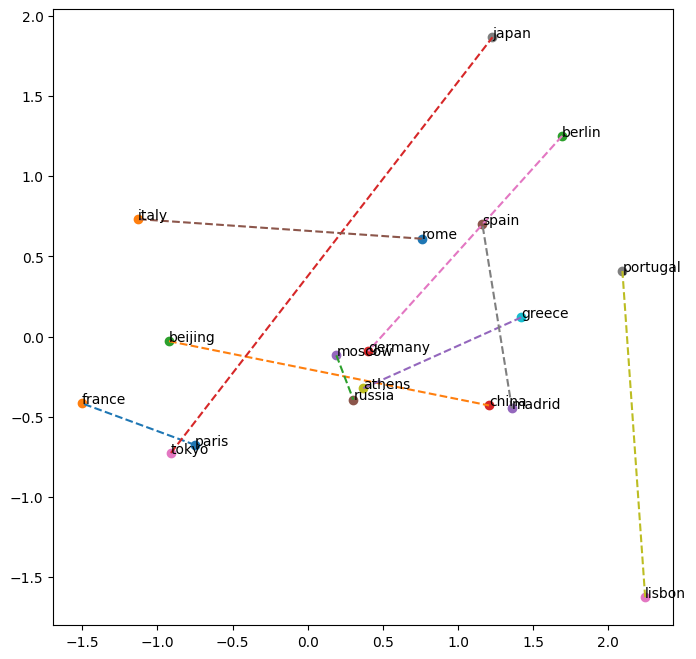

In [385]:
projected = projector.transform(vectors.detach().cpu())

plt.figure(figsize=(8,8))
for i in range(0, len(projected), 2):
    pair = sample_word_pairs[i // 2]

    plt.plot(projected[i:i+2, 0], projected[i:i+2, 1], '--')

    for j in range(2):
        x, y = projected[i+j, 0], projected[i+j, 1]
        plt.scatter(x, y)
        plt.text(x, y, pair[j])

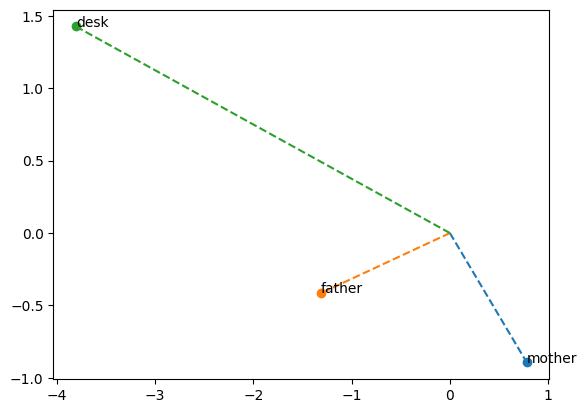

In [386]:
demo = 'mother father desk'
projected = projector.transform(get_vector(demo).detach().cpu())
for j in range(len(demo.split())):
  x, y = projected[j, 0], projected[j, 1]
  plt.scatter(x, y)
  plt.text(x, y, tokenizer(demo)[j])
  plt.plot(torch.Tensor([0, x]), torch.Tensor([0, y]), '--')

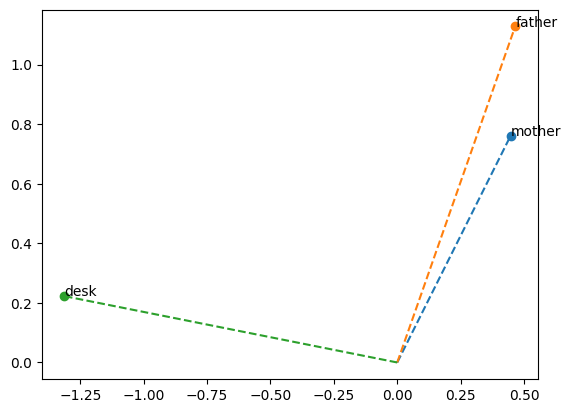

In [ ]:
# demo = 'mother father desk'
# projected = pca.transform(get_vector(demo).detach().cpu())
# for j in range(3):
#   x, y = projected[j, 0], projected[j, 1]
#   plt.scatter(x, y)
#   plt.text(x, y, tokenizer(demo)[j])
#   plt.plot(torch.Tensor([0, x]), torch.Tensor([0, y]), '--')

## Simple QA / relationship inference

prove linear composability


In [387]:
question = get_vector('berlin') - get_vector('germany')

In [388]:
acc = 0

metric = nn.CosineSimilarity()
choices = [capital for capital, country in sample_word_pairs]
for capital, country in sample_word_pairs:
  print('question:', country)
  guess = metric(question + get_vector(country), get_vector(" ".join(choices)))
  # guess = metric(question, model.embeddings.weight)
  # print(guess)
  topk_guess_value, topk_guess_idx = guess.topk(3, largest=True)
  answer = [choices[g] for g in topk_guess_idx]
  print(topk_guess_value)
  # answer = vocab.lookup_tokens([guess[4:].abs().argmin()])
  print('answer:', answer)
  print('-------------------------------')

  acc += answer[0] == capital

print(f"{acc}/{len(sample_word_pairs)}")

question: france
tensor([0.5920, 0.0461, 0.0130], device='cuda:0')
answer: ['berlin', 'beijing', 'rome']
-------------------------------
question: china
tensor([0.5827, 0.0960, 0.0737], device='cuda:0')
answer: ['berlin', 'athens', 'beijing']
-------------------------------
question: russia
tensor([0.5642, 0.0994, 0.0861], device='cuda:0')
answer: ['berlin', 'beijing', 'paris']
-------------------------------
question: japan
tensor([0.5794, 0.0735, 0.0387], device='cuda:0')
answer: ['berlin', 'moscow', 'beijing']
-------------------------------
question: greece
tensor([0.5650, 0.1255, 0.0694], device='cuda:0')
answer: ['berlin', 'beijing', 'athens']
-------------------------------
question: italy
tensor([0.6387, 0.1244, 0.1070], device='cuda:0')
answer: ['berlin', 'beijing', 'rome']
-------------------------------
question: germany
tensor([1.0000, 0.0849, 0.0374], device='cuda:0')
answer: ['berlin', 'lisbon', 'madrid']
-------------------------------
question: spain
tensor([0.6523, 0.1

## phrase construction


In [ ]:
# bigram count / unigram product => keep filtering

torch.Size([6, 128])

In [487]:
train_datapipe, val_datapipe, test_datapipe = WikiText2("./data")

In [488]:
ngrams_counter = Counter()
for data in datapipe_factory(train_datapipe):
    ngrams_counter.update(ngrams_iterator(data, 2))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [489]:
for stopword in stopwords.words('english'):
    ngrams_counter.pop(stopword, "")

import string

for stopword in string.ascii_letters + string.punctuation:
    ngrams_counter.pop(stopword, "")

In [490]:
iter_limit = 1
frequent_word_threshold = sum(counter) * 1e-4
count_threshold = 5e-5
count_threshold_factor = 0.8

In [491]:
phrases = set()
bigrams = [key for key in ngrams_counter.keys() if " " in key and key != ""]
for _ in range(iter_limit):
   for bigram in tqdm(bigrams):
      gram1, gram2 = bigram.split(" ")
      gram1_count, gram2_count = ngrams_counter[gram1], ngrams_counter[gram2]

      if gram1_count > frequent_word_threshold or gram2_count > frequent_word_threshold:
         continue

      if gram1_count == 0 or gram2_count == 0:
         continue

      lift = ngrams_counter[bigram] / (gram1_count * gram2_count)
      # print(bigram, lift)
      if lift > count_threshold:
         phrases.add(bigram)
      else:
         bigrams.remove(bigram)
      
      count_threshold *= count_threshold_factor

100%|█████████▉| 577048/577049 [00:00<00:00, 672551.02it/s]


In [ ]:
phrases

In [493]:
ngrams_counter['video game'] / (ngrams_counter['video'] * ngrams_counter['game'])

7.172148157986485e-05

In [494]:
'video game' in phrases

True